In [1]:
"""
Copyright 2021 Huawei Technologies Co., Ltd

CREATED:  2020-6-04 20:12:13
MODIFIED: 2021-11-25 11:48:45
"""

import os
import cv2
import numpy as np

# -*- coding:utf-8 -*-
from model.acl import Model
from PIL import Image, ImageDraw, ImageFont

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device_id = 0

model1_path = "weights/craft.om"
model2_path = "weights/None-ResNet-None-CTC.om"

image_path = "data/images/test_305.jpg"
boxes_path = "data/polygons/res_test_305.txt"

font_path = "data/fonts/OpenSans_Condensed-SemiBold.ttf"

cropped = False
character = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
thresholds = {"text_thresh":0.7, "link_thresh":0.4, "low_text":0.4}

In [4]:
# load image
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

In [5]:
# model1 load
model1 = Model(device_id, model1_path, thresholds = thresholds)

[ACL] init resource stage:
[ACL] init resource stage success
[MODEL] class Model init resource stage:
[MODEL] create model output dataset:
[MODEL] create model output dataset success
model input size 1
input  0
model input dims ({'name': 'input.1', 'dimCount': 4, 'dims': [1, 3, 736, 1280]}, 0)
model input datatype 0
model output size 1
output  0
model output dims ({'name': 'Transpose_86:0', 'dimCount': 4, 'dims': [1, 368, 640, 2]}, 0)
model output datatype 0
[PROCESS] init process success
[MODEL] class Model init resource stage success


In [6]:
# model1 run
bboxes = polys = None
bboxes, polys = model1.run(img_rgb)

[PreProc] image_np_expanded shape: (1, 3, 736, 1280)
[ACL] img_host_ptr, img_buf_size:  94466805463360 11304960
[ACL] img_dev_ptr, img_buf_size:  18143032377344 11304960
[MODEL] create model input dataset:
[MODEL] create model input dataset success
[MODEL] execute stage:
[MODEL] execute stage success
[RESULT] infer / postproc time : 0.084 / 0.034


In [7]:
# get coordinates of the boxes and draw on the picture
boxes_coord = []
for poly in polys:
    poly = np.array(poly).astype(np.int32).reshape((-1))
    boxes_coord.append(poly.tolist())
    
    poly = poly.reshape(-1, 2)
    cv2.polylines(img_bgr, [poly.reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=2)
    
print(boxes_coord)

[[786, 152, 870, 152, 870, 180, 786, 180], [520, 154, 612, 154, 612, 174, 520, 174], [616, 154, 670, 154, 670, 174, 616, 174], [674, 153, 684, 155, 707, 157, 724, 159, 747, 155, 766, 159, 784, 159, 783, 178, 765, 178, 746, 174, 726, 178, 706, 176, 682, 174, 673, 172], [815, 249, 841, 247, 868, 248, 891, 246, 918, 247, 953, 250, 973, 253, 971, 281, 951, 278, 914, 275, 895, 273, 866, 276, 841, 275, 815, 277], [493, 254, 518, 253, 548, 253, 593, 250, 646, 255, 666, 248, 704, 240, 708, 273, 670, 281, 646, 288, 592, 283, 550, 286, 517, 286, 493, 288], [966, 252, 1022, 252, 1022, 272, 966, 272], [1028, 252, 1058, 252, 1058, 276, 1028, 276], [386, 254, 408, 254, 408, 292, 386, 292], [744, 256, 818, 256, 818, 276, 744, 276]]


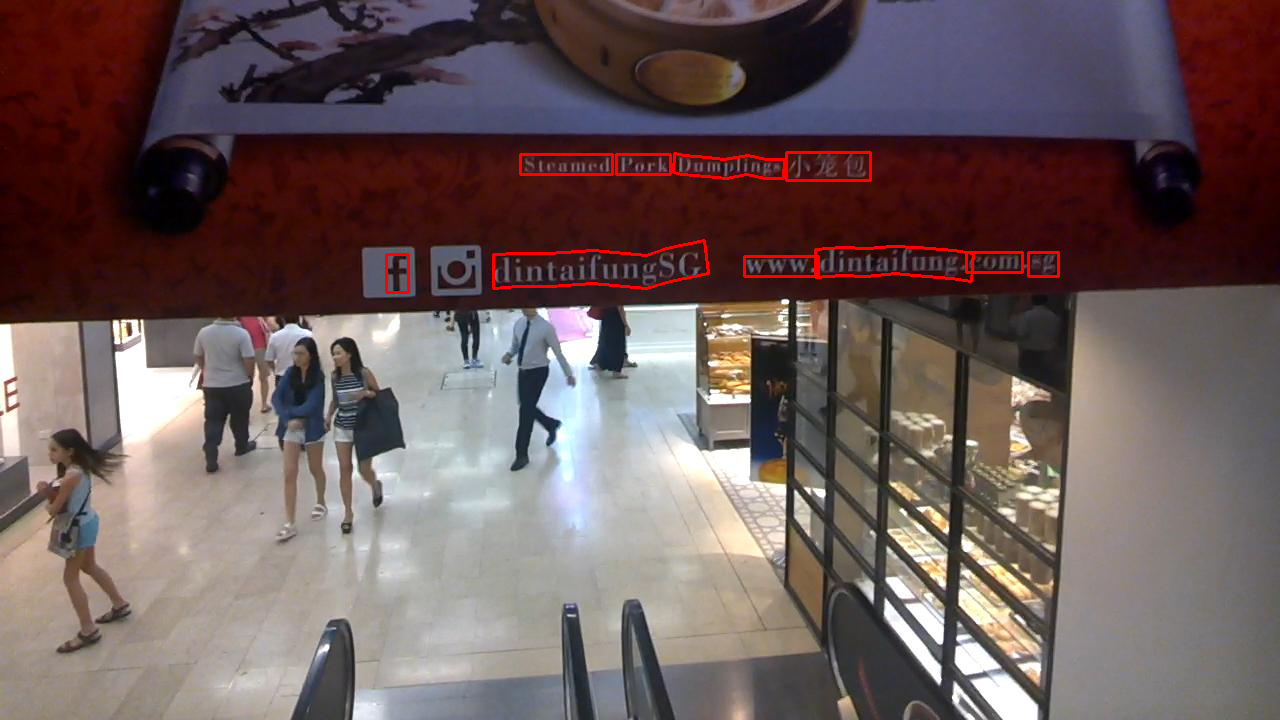

In [8]:
# show score text
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_rgb_plw = Image.fromarray(img_rgb)
img_rgb_plw

In [9]:
# load boxes from text file(if you have two network, skip this step)
vertical_positions = None
with open(boxes_path, 'r') as bbox_f: # read coordinates of extracted bounding boxes from text file
    box_coords = [line.rstrip('\n') for line in bbox_f]
vertical_positions = np.argsort(np.asarray([int(y0.split(',')[1]) for y0 in box_coords]))

boxes_coord = []
for i in vertical_positions:
    line = box_coords[i]
    boxes_coord.append([int(i) for i in line.split(',')])
    
print(boxes_coord)

[[786, 152, 870, 152, 870, 180, 786, 180], [674, 153, 684, 155, 707, 157, 723, 159, 747, 155, 766, 159, 784, 159, 783, 178, 765, 178, 746, 174, 726, 178, 706, 176, 682, 174, 673, 172], [520, 154, 612, 154, 612, 174, 520, 174], [616, 154, 670, 154, 670, 174, 616, 174], [815, 249, 841, 247, 867, 247, 891, 246, 918, 247, 953, 250, 973, 253, 971, 281, 951, 278, 914, 275, 895, 273, 866, 276, 841, 275, 815, 277], [966, 252, 1022, 252, 1022, 272, 966, 272], [1020, 252, 1058, 252, 1058, 276, 1020, 276], [493, 254, 517, 253, 548, 253, 593, 250, 646, 255, 666, 248, 704, 240, 708, 273, 670, 281, 646, 288, 592, 283, 550, 286, 517, 286, 493, 288], [386, 254, 408, 254, 408, 292, 386, 292], [744, 256, 818, 256, 818, 276, 744, 276]]


In [10]:
# model2 load
model2 = Model(device_id, model2_path, character)

[ACL] init resource stage:
[ACL] init resource stage success
[MODEL] class Model init resource stage:
[MODEL] create model output dataset:
[MODEL] create model output dataset success
model input size 1
input  0
model input dims ({'name': 'input', 'dimCount': 4, 'dims': [1, 1, 32, 100]}, 0)
model input datatype 0
model output size 1
output  0
model output dims ({'name': 'Add_78:0', 'dimCount': 3, 'dims': [1, 26, 37]}, 0)
model output datatype 0
[PROCESS] init process success
[MODEL] class Model init resource stage success


In [11]:
# model2 run
bboxes = None
bboxes = model2.run(img_bgr, boxes_coord, cropped = cropped)

[INFO] recognizing texts . . .
[INFO] loading text boxes . . .
[INFO]  10 text boxes found.
[PreProc] image_np_expanded shape: (1, 1, 32, 100)
[ACL] img_host_ptr, img_buf_size:  94466802489152 12800
[ACL] img_dev_ptr, img_buf_size:  18143021580288 12800
[MODEL] create model input dataset:
[MODEL] create model input dataset success
[MODEL] execute stage:
[MODEL] execute stage success
[PreProc] image_np_expanded shape: (1, 1, 32, 100)
[ACL] img_host_ptr, img_buf_size:  94466802489152 12800
[ACL] img_dev_ptr, img_buf_size:  18143021580288 12800
[MODEL] create model input dataset:
[MODEL] create model input dataset success
[MODEL] execute stage:
[MODEL] execute stage success
[PreProc] image_np_expanded shape: (1, 1, 32, 100)
[ACL] img_host_ptr, img_buf_size:  94466802489152 12800
[ACL] img_dev_ptr, img_buf_size:  18143021580288 12800
[MODEL] create model input dataset:
[MODEL] create model input dataset success
[MODEL] execute stage:
[MODEL] execute stage success
[PreProc] image_np_expande

In [12]:
# get results
img_rgb_plw = Image.fromarray(img_rgb)
s = draw = None
draw = ImageDraw.Draw(img_rgb_plw)
font = ImageFont.truetype(font_path, 18)
s = ""

for b in bboxes:
    points = b.get_points()
    arry_points = tuple(map(tuple, np.array(points).astype("int32").reshape([-1, int(len(points) / 2), 2])[0]))
    draw.polygon(arry_points, outline="red")
    draw.text((points[0], points[1]-20), b.get_text(), font=font, fill='green')
    s+=b.get_text() + " "

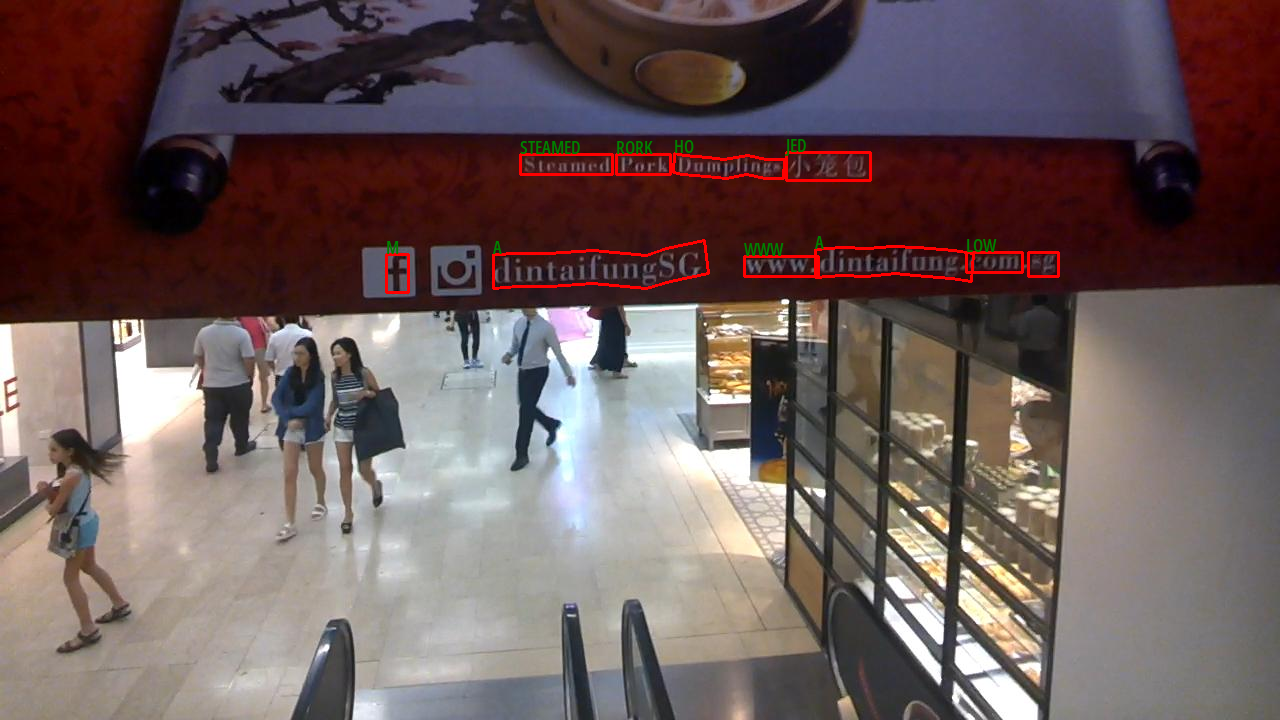

In [13]:
# show outputs
img_rgb_plw

In [14]:
# show output texts
print("[Result] image texts :", s)

[Result] image texts : STEAMED RORK HO JED A A M WWW LOW 
